# Imports

The **services module** contains functions for accessing third party bioemdical data services.

In [1]:
from services.pdb import pfam, pdbligand, pdbmolecule
from services.classyfire import classyfire
from services.uniprot import pdb2uniprot
from services.uniprot import pdb2uniprotAC
from services.uniprot import entry2ACC
from services.pubchem import get_image
from collections import defaultdict
from tqdm import tqdm
from math import ceil
import pandas as pd

##### PDB
For PDB we have functions for quering information about (1) PDB files, (2) Protein Molecules, (3) Ligands, (4) PFam Annotations and (5) GO annotations.  

##### Uniprot
For Uniprot we query a service that maps pdb IDs to uniprot IDs. 

# Pocket Feature Graph

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

##### Step 1. Convert pocket feature scores to "cosine similarities"

Given a matrix $X \in \mathbb R ^n$ with rows $x_i$, we compute the cosine similarity between two rows as:

$$ \frac{x_i^T x_j}{\lVert x_i \rVert \lVert x_j \rVert }$$

Given symmetric positive semidefinite matrix $A = X X^T$, we can compute cosine similarities using hte formula:

$$\frac{a_{ij}}{\sqrt{a_{ii}}\sqrt{a_{jj}}} = \frac{x_i^T x_j}{\lVert x_i \rVert \lVert x_j \rVert }$$ 

In [3]:
# Read in pocket feature similarities and convert to an adjacency matrix
# Replace './data/pocket_feature_scores.csv' with your pocket feature score matrix. 
pf = pd.read_csv('./data/pocket_feature_scores.csv', header=None, names=['pocket_0', 'pocket_1', 'weight'])
pf_matrix = pf.pivot(index='pocket_0', columns='pocket_1', values='weight')

# Compute cosine similarities from pocket feature score matrix
diagonal = np.sqrt(np.diag(-1*pf_matrix))
denominator = np.outer(diagonal, diagonal)
normalized = (-1*pf_matrix)/denominator

FileNotFoundError: [Errno 2] File ./data/pocket_feature_scores.csv does not exist: './data/pocket_feature_scores.csv'

##### Step 2. Filter cosine similarities

In order to reduce memory and computational costs, we filter out cosine slimilarity values that fall outside of a range of interest.  For example, we may wish to exclude low similarity values.  Likewise, we do not wish to have self referencing edges in our graph, so we also filter out diagonal values in the adjacency matrix.

In [4]:
# Specify desired range
score_range = [0, 1]
lower_limit = score_range[0]
upper_limit = score_range[1]

# Set matrix entries out of specificed range to NaN
if lower_limit > 0:
    normalized[normalized < lower_limit] = np.nan
if upper_limit < 1:
    normalized[normalized > upper_limit] = np.nan

# Set off Diagonal to NaN
np.fill_diagonal(normalized.values, np.nan)

#### Steb 2b. Get sequence Similarities

In [5]:
lines = []
for i in range(10):
    new_df = pd.read_csv('seqAlign_' + str(i) +'.csv', index_col=0)
    lines.append(new_df)
seq_align = pd.concat(lines, axis=0)
seq_align = seq_align.loc[:, (seq_align != 0).any(axis=0)]
seq_align = seq_align.loc[(seq_align != 0).any(axis=1), :]

In [6]:
diagonal = np.diag(seq_align)
denominator = np.maximum.outer(diagonal, diagonal)
normalized_seq = (seq_align)/denominator

In [7]:
seq_align_col = normalized_seq.stack().reset_index()
seq_align_col.columns = ['pocket_0', 'pocket_1', 'align_score']

          pocket_0  pocket_1  align_score
0         4gmg_NAP  4gmg_NAP     1.000000
1         4gmg_NAP  2jah_NDP     0.024185
2         4gmg_NAP  5ark_UMP     0.017566
3         4gmg_NAP  1oaa_NAP     0.028259
4         4gmg_NAP  3plp_BBA     0.017312
...            ...       ...          ...
22657595  1o69_X04  3kxo_KXO     0.020342
22657596  1o69_X04  3pnb_COA     0.019086
22657597  1o69_X04  4usr_FAD     0.019086
22657598  1o69_X04  4poo_SAM     0.028880
22657599  1o69_X04  1o69_X04     1.000000

[22657600 rows x 3 columns]


##### Step 3. Initialize PF Similarity Graph

In [8]:
# Convert from adjacency matrix to edge list
normalized_edges = normalized.stack().reset_index()
normalized_edges = normalized_edges.rename(columns={0:'weight'})
merged_normalized_edges = normalized_edges.merge(seq_align_col, how='left', on=['pocket_0', 'pocket_1'])

In [9]:
# Split off ligand IDs from pocket IDs and add them as separate columns
new = merged_normalized_edges['pocket_0'].str.split("_", expand = True)
merged_normalized_edges['ligand_0'] = new[1]

new = merged_normalized_edges['pocket_1'].str.split("_", expand = True)
merged_normalized_edges['ligand_1'] = new[1]

In [10]:
merged_normalized_edges['score'] = merged_normalized_edges['weight'] / merged_normalized_edges['align_score']

In [11]:
# Initialize graph
PFG = nx.Graph()

# Iterate through rows of edge list dataframe
for row in merged_normalized_edges.itertuples():
    
    # If both ligand are the same, do nothing
    ligand_0 = row.ligand_0
    ligand_1 = row.ligand_1
    if ligand_0 == ligand_1:
        continue
        
    # If ligands are different, we pull out pocket IDs and pf cosine similarity
    pocket_0 = row.pocket_0    
    pocket_1 = row.pocket_1
    weight = row.score #changed from weight for new seq_align edits
    
    # If we have not seen this pair of ligand before, we add an edge
    if not PFG.has_edge(ligand_0, ligand_1):
        PFG.add_edge(ligand_0, ligand_1, id=[pocket_0, pocket_1], weight=weight)
        
    # Otherise update the edge weight if pf cosine similarity is greater than previous max
    elif weight > PFG[ligand_0][ligand_1]['weight']:
        PFG[ligand_0][ligand_1]['id'] = [pocket_0, pocket_1]
        PFG[ligand_0][ligand_1]['weight'] = weight

# Scaffold Hop Scores

We define a scaffold hop score for a pair of ligands as:

$$max\left(\frac{F(m_1, m_2)}{T(m_1,m_2)}\right)$$

Where $m_i$ denotes a ligand in our dataset, $F$ is the pocket feature cosine similarity between bound protein structures, and $T$ is the tanomoto coefficient between chemical fingerprints.  Ligands may be bound in multiple co-crystal structures, and for any pair of ligands there may be a range of scaffold hop scores.  We take the maximum value.  In general, the high scaffold hop scores corrspond to ligands with dissimilar strucutres, that bind slimilar protein pockets.

In [12]:
# Import ligand tanomoto matrix
ligand_matrix = pd.read_csv('./data/ligandComparisons.csv', index_col=0)

In [13]:
SHG = PFG.copy()
for ligand_0, ligand_1 in PFG.edges:
    ligand_score = ligand_matrix[ligand_0][ligand_1]
    pf_score = PFG[ligand_0][ligand_1]['weight']
    
    SHG[ligand_0][ligand_1]['weight'] = pf_score/ligand_score

# Filtering

Optional filtering to remove identical proteins.

In [14]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [15]:
from networkx.algorithms import bipartite

def projected_graph(Graph):
    nx.set_node_attributes(Graph, bipartite.color(Graph), name='color')

    top = [i for i in Graph.nodes if Graph.nodes[i]['color'] == 1]
    projected = bipartite.overlap_weighted_projected_graph(Graph, top)
    return projected

all_pockets = []
for u,v in SHG.edges:
    pockets = SHG[u][v]['id']
    all_pockets.extend(pockets)
    
structures, ligands = zip( *[i.split('_') for i in set(all_pockets)] )
structures = list(set(structures))

pdb_uniprot_mapping = pd.read_csv(pdb2uniprot(structures), sep='\t')

PUG = nx.from_pandas_edgelist(pdb_uniprot_mapping, source='From', target='To')
uniprot_filter = projected_graph(PUG)

In [16]:
filtered = SHG.copy()
for u,v in SHG.edges:
    try:
        pdb_0, pdb_1 = [i.split('_')[0] for i in filtered[u][v]['id']]
        if uniprot_filter[pdb_0][pdb_1]['weight'] >= 0.5:
            filtered.remove_edge(u,v)
    except KeyError:
        pass

# Results

In [17]:
from pprint import pprint

# pprint(sorted(SHG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10])
# sorted_scores = sorted(SHG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

pprint(sorted(filtered.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10])
sorted_scores = sorted(filtered.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

[('VNL', '1X3', {'id': ['4ktc_1X3', '2y2x_VNL'], 'weight': 150.7048841803188}),
 ('ANP', 'CPS', {'id': ['2pul_CPS', '2jlr_ANP'], 'weight': 150.41884597631892}),
 ('R71', 'SFG', {'id': ['2xyr_SFG', '1w6j_R71'], 'weight': 147.12081971409467}),
 ('ANP', 'IXH', {'id': ['3bea_IXH', '1zy5_ANP'], 'weight': 143.11581492766067}),
 ('ANP', 'BPQ', {'id': ['3bll_BPQ', '2jlr_ANP'], 'weight': 142.72281183456872}),
 ('ANP', 'SAH', {'id': ['4z4p_SAH', '2bif_ANP'], 'weight': 139.260159842887}),
 ('ANP', 'ADP', {'id': ['1w5t_ADP', '1v25_ANP'], 'weight': nan}),
 ('ANP', 'EQU', {'id': ['3myk_ANP', '3ipt_EQU'], 'weight': 218.7729232555969}),
 ('ANP', 'VMS', {'id': ['1wk8_VMS', '1v25_ANP'], 'weight': nan}),
 ('ANP', 'TSU', {'id': ['3fxu_TSU', '2jlr_ANP'], 'weight': 166.78213695245137})]


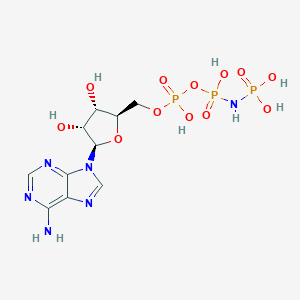

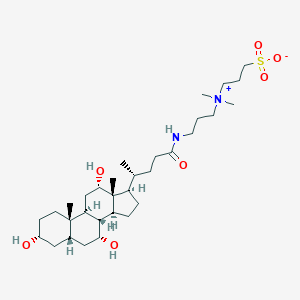

In [18]:
import IPython.display as Disp

# image size can be 'large' or 'small'
image_size = 'large'

# Pick an index of example to inspect 
idx = 1

# everything below pulls info about example
edge = sorted_scores[idx]
lig_0 = edge[0]
lig_1 = edge[1]

lig_info = pdbligand( ','.join([lig_0, lig_1]) )
keys = ['chemicalID','chemicalName', 'formula', 'molecularWeight']
classes = []
for info in lig_info:
    inchi = info['InChIKey']
    co_classes = classyfire(inchi)
    classes.append(co_classes)
    txt = [co_classes['direct_parent']['name'], co_classes['description']]
    image = get_image(inchi, image_size=image_size)
#     url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchi}/PNG?image_size={image_size}' 
#     image = requests.get(url).content
    text = '<br>'.join( [info[key].upper() for key in keys] + txt )
    Disp.display( Disp.Image(image), Disp.HTML(text) )

In [19]:
def extract_pdbids(edge_data):
    pdbs = edge_data['id']
    return ','.join([i.split('_')[0] for i in pdbs])

pprint(pdbmolecule(extract_pdbids(edge[2])))

[{'id': '2PUL',
  'polymer': {'Taxonomy': {'id': '1423', 'name': 'Bacillus subtilis'},
              'chain': [{'id': 'A'}, {'id': 'B'}],
              'entityNr': '1',
              'enzClass': {'ec': '2.7.1.100'},
              'length': '397',
              'macroMolecule': {'accession': {'id': 'O31663'},
                                'name': 'Methylthioribose kinase'},
              'polymerDescription': {'description': 'Methylthioribose kinase'},
              'synonym': {'name': 'MTR kinase'},
              'type': 'protein',
              'weight': '45140.0'}},
 {'id': '2JLR',
  'polymer': {'Taxonomy': {'id': '12637', 'name': 'Dengue virus'},
              'chain': {'id': 'A'},
              'entityNr': '1',
              'enzClass': {'ec': '3.4.21.91'},
              'fragment': {'desc': 'RESIDUES 1646-2092'},
              'length': '451',
              'macroMolecule': {'accession': {'id': 'Q2YHF0'},
                                'name': 'Genome polyprotein'},
           